# Phones Factor Analysis
The code below calculates additional factors from the dataset and tests their effectiveness in training with Logistic Regression and Random Forest

Factors are:
- ARI (Readability)
- Review Length
- punctuation
- capitalisation
- edit&update
- adjectives

In [1]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import re 
from collections import Counter
from string import punctuation
import textstat # pip install textstat

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [2]:
df = pd.read_json('../Datasets/Modified_Phones_rating.json', lines=True)
df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews
0,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,100,51,1,item arrived great time perfect condition howe...
1,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,66,23,0,awesome stay look great used multiple apple pr...
2,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,66,44,0,good case solid build protects phone around go...
3,"[2, 3]",This is the first battery case I have had for ...,5,A Winner,2,3,66,71,0,this first battery case i galaxy s the s fit w...
4,"[3, 3]",Performs exactly as advertised . It's very st...,5,Absolutely love the case !!,3,3,100,47,1,performs exactly advertised it sturdily builta...


## ARI

In [3]:
def calculate_ari(text):
    ari = textstat.automated_readability_index(text)
    return ari

df['ARI'] = df['Review'].apply(calculate_ari)
df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI
0,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,100,51,1,item arrived great time perfect condition howe...,5.7
1,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,66,23,0,awesome stay look great used multiple apple pr...,5.3
2,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,66,44,0,good case solid build protects phone around go...,3.5
3,"[2, 3]",This is the first battery case I have had for ...,5,A Winner,2,3,66,71,0,this first battery case i galaxy s the s fit w...,3.3
4,"[3, 3]",Performs exactly as advertised . It's very st...,5,Absolutely love the case !!,3,3,100,47,1,performs exactly advertised it sturdily builta...,4.7


In [4]:
# number of reviews with an ARI < 8 (equals 3rd grade level and is very easy to read)
low_ari_reviews = df[df['ARI'] < 8]
num_low_ari_reviews = len(low_ari_reviews)

print(f"Number of Reviews with ARI < 8: {num_low_ari_reviews}")

Number of Reviews with ARI < 8: 10913


In [5]:
def convert_ari(df):
    if df['ARI'] <= 8.0:
        ari = 1 # for readable
    else:
        ari = 0 # for not readable
    return ari

df['IsReadable'] = df.apply(convert_ari, axis=1)
df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI,IsReadable
0,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,100,51,1,item arrived great time perfect condition howe...,5.7,1
1,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,66,23,0,awesome stay look great used multiple apple pr...,5.3,1
2,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,66,44,0,good case solid build protects phone around go...,3.5,1
3,"[2, 3]",This is the first battery case I have had for ...,5,A Winner,2,3,66,71,0,this first battery case i galaxy s the s fit w...,3.3,1
4,"[3, 3]",Performs exactly as advertised . It's very st...,5,Absolutely love the case !!,3,3,100,47,1,performs exactly advertised it sturdily builta...,4.7,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'IsReadable']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['IsReadable'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['IsReadable'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.6787479406919276
Random Forest Accuracy: 0.6617243272926964

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.26      0.36      1266
           1       0.70      0.90      0.79      2376

    accuracy                           0.68      3642
   macro avg       0.64      0.58      0.57      3642
weighted avg       0.66      0.68      0.64      3642


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.09      0.16      1266
           1       0.67      0.97      0.79      2376

    accuracy                           0.66      3642
   macro avg       0.63      0.53      0.47      3642
weighted avg       0.64      0.66      0.57      3642



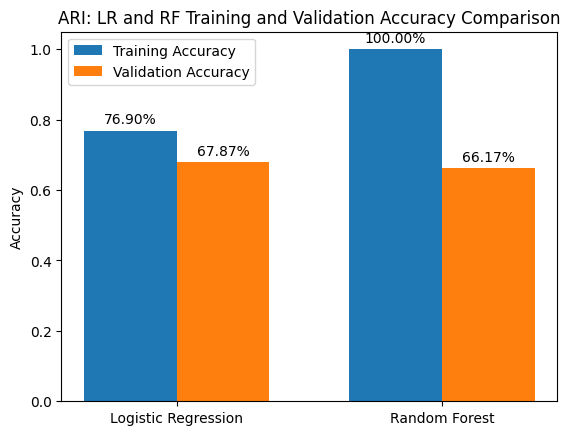

In [7]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

ari_lr_train_accuracy = lr_train_accuracy
ari_rf_train_accuracy = rf_train_accuracy

ari_lr_test_accuracy = lr_accuracy
ari_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('ARI: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Review Length

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'review_len']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['review_len'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['review_len'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.6771004942339374
Random Forest Accuracy: 0.6655683690280065

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.28      0.38      1266
           1       0.70      0.89      0.78      2376

    accuracy                           0.68      3642
   macro avg       0.64      0.59      0.58      3642
weighted avg       0.65      0.68      0.64      3642


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.10      0.17      1266
           1       0.67      0.97      0.79      2376

    accuracy                           0.67      3642
   macro avg       0.64      0.53      0.48      3642
weighted avg       0.65      0.67      0.57      3642



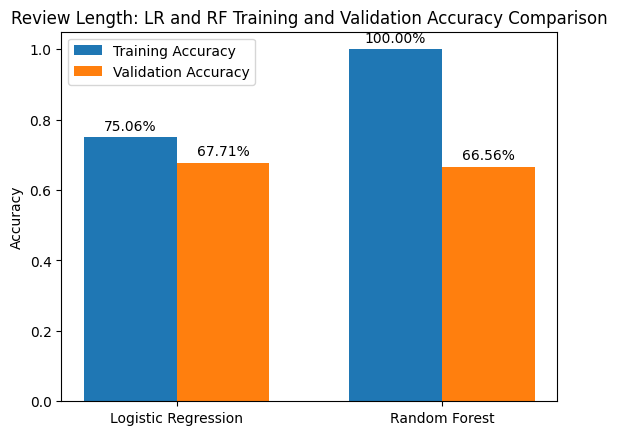

In [9]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

len_lr_train_accuracy = lr_train_accuracy
len_rf_train_accuracy = rf_train_accuracy

len_lr_test_accuracy = lr_accuracy
len_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Review Length: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Punctuation Marks

In [10]:
# Get punctuation ratio (! and ?)
df['ExclamationMarks_Count'] = df['Review'].str.count('!')
df['QuestionMarks_Count'] = df['Review'].str.count('\?')

# Calculate Ratio/Percent of Punc. Marks relative to review length
df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Count'] / df['review_len']
df['QuestionMarks_Ratio'] = df['QuestionMarks_Count'] / df['review_len']

df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Ratio'].fillna(0)
df['QuestionMarks_Ratio'] = df['QuestionMarks_Ratio'].fillna(0)

df['ExclamationMarks_Percent'] = (df['ExclamationMarks_Ratio'] * 100).astype(int)
df['QuestionMarks_Percent'] = (df['QuestionMarks_Ratio'] * 100).astype(int)

# combine both
df['Sum_punctuationMarks'] = df['ExclamationMarks_Percent'] + df['QuestionMarks_Percent']

# delete unused columns:
df.drop(['ExclamationMarks_Count', 'QuestionMarks_Count','ExclamationMarks_Ratio', 'QuestionMarks_Ratio','ExclamationMarks_Percent', 'QuestionMarks_Percent'], axis='columns', inplace=True)

df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI,IsReadable,Sum_punctuationMarks
0,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,100,51,1,item arrived great time perfect condition howe...,5.7,1,0
1,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,66,23,0,awesome stay look great used multiple apple pr...,5.3,1,4
2,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,66,44,0,good case solid build protects phone around go...,3.5,1,0
3,"[2, 3]",This is the first battery case I have had for ...,5,A Winner,2,3,66,71,0,this first battery case i galaxy s the s fit w...,3.3,1,0
4,"[3, 3]",Performs exactly as advertised . It's very st...,5,Absolutely love the case !!,3,3,100,47,1,performs exactly advertised it sturdily builta...,4.7,1,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'Sum_punctuationMarks']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['Sum_punctuationMarks'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['Sum_punctuationMarks'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.6760021965952773
Random Forest Accuracy: 0.6683141131246568

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.25      0.35      1266
           1       0.69      0.90      0.78      2376

    accuracy                           0.68      3642
   macro avg       0.64      0.58      0.57      3642
weighted avg       0.65      0.68      0.63      3642


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.10      0.17      1266
           1       0.67      0.97      0.79      2376

    accuracy                           0.67      3642
   macro avg       0.66      0.54      0.48      3642
weighted avg       0.66      0.67      0.58      3642



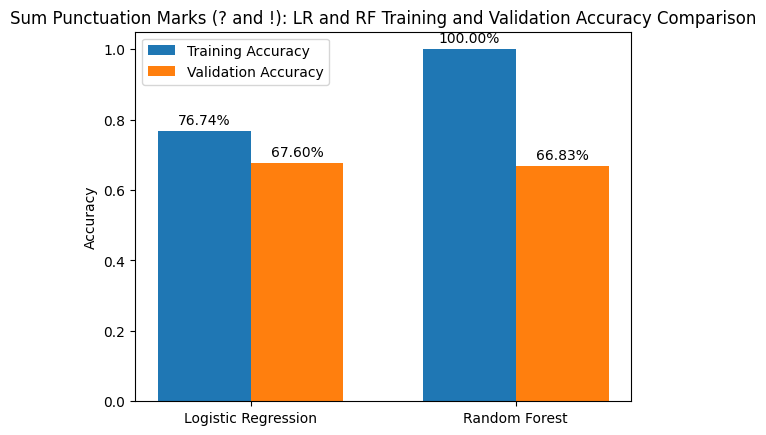

In [12]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

pct_lr_train_accuracy = lr_train_accuracy
pct_rf_train_accuracy = rf_train_accuracy

pct_lr_test_accuracy = lr_accuracy
pct_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Sum Punctuation Marks (? and !): LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Capitalisation
Words written with Capslock

In [13]:
df['Capslock_Count'] = df['Review'].str.findall(r'\b(?![Ii]\b)[A-Z]+\b').str.len()
df['Capslock_Ratio'] = df['Capslock_Count'] / df['review_len']
df['Capslock_Ratio'] = df['Capslock_Ratio'].fillna(0)
df['Capslock_Percent'] = (df['Capslock_Ratio'] * 100).astype(int)
df.drop(['Capslock_Count','Capslock_Ratio'], axis='columns', inplace=True)
df.head()

,helpful,Review,Rating,Title,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI,IsReadable,Sum_punctuationMarks,Capslock_Percent
0,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,4,4,100,51,1,item arrived great time perfect condition howe...,5.7,1,0,1
1,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,2,3,66,23,0,awesome stay look great used multiple apple pr...,5.3,1,4,0
2,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,2,3,66,44,0,good case solid build protects phone around go...,3.5,1,0,0
3,"[2, 3]",This is the first battery case I have had for ...,5,A Winner,2,3,66,71,0,this first battery case i galaxy s the s fit w...,3.3,1,0,0
4,"[3, 3]",Performs exactly as advertised . It's very st...,5,Absolutely love the case !!,3,3,100,47,1,performs exactly advertised it sturdily builta...,4.7,1,0,6


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'Capslock_Percent']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['Capslock_Percent'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['Capslock_Percent'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.6746293245469522
Random Forest Accuracy: 0.6647446457990115

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.26      0.35      1266
           1       0.69      0.90      0.78      2376

    accuracy                           0.67      3642
   macro avg       0.63      0.58      0.57      3642
weighted avg       0.65      0.67      0.63      3642


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.09      0.16      1266
           1       0.67      0.97      0.79      2376

    accuracy                           0.66      3642
   macro avg       0.65      0.53      0.47      3642
weighted avg       0.65      0.66      0.57      3642



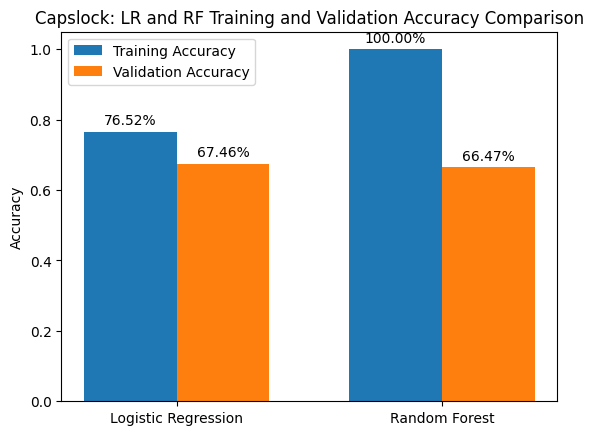

In [15]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

cap_lr_train_accuracy = lr_train_accuracy
cap_rf_train_accuracy = rf_train_accuracy

cap_lr_test_accuracy = lr_accuracy
cap_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Capslock: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Edits & Updates

In [16]:
df['contains_updates'] = df['Review'].str.contains('contains_updates', case=False).astype(int)

X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'contains_updates']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['contains_updates'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['contains_updates'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.6773750686436024
Random Forest Accuracy: 0.6691378363536519

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.26      0.36      1266
           1       0.69      0.90      0.78      2376

    accuracy                           0.68      3642
   macro avg       0.64      0.58      0.57      3642
weighted avg       0.66      0.68      0.64      3642


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.09      0.16      1266
           1       0.67      0.98      0.79      2376

    accuracy                           0.67      3642
   macro avg       0.67      0.53      0.48      3642
weighted avg       0.67      0.67      0.57      3642



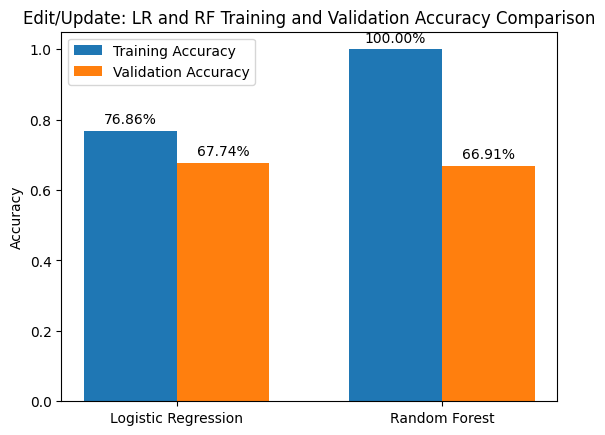

In [17]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

ed_lr_train_accuracy = lr_train_accuracy
ed_rf_train_accuracy = rf_train_accuracy

ed_lr_test_accuracy = lr_accuracy
ed_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Edit/Update: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

## Rating

In [18]:
# Drop rows with NaN values in 'cleaned_reviews'
df = df.dropna(subset=['cleaned_reviews'])

X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_reviews', 'Rating']], df['IsHelpful'], test_size=0.2, random_state=42)
# feature extraction
vectorizer = TfidfVectorizer(max_features=6000) # ca 10% von Datensatz Phones
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_reviews'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_reviews'])

# Hinzufügen der 'IsReadable'-Spalte zu den TF-IDF-Matrizen
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), X_train['Rating'].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), X_test['Rating'].reset_index(drop=True)], axis=1)

X_train_final.shape, X_test_final.shape

# Convert column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_final)
rf_preds = rf_model.predict(X_test_final)

# Evaluate models
lr_accuracy = accuracy_score(y_test, lr_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# Additional evaluation metrics
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, lr_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

Logistic Regression Accuracy: 0.6985172981878089
Random Forest Accuracy: 0.6913783635365184

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.41      0.48      1266
           1       0.73      0.85      0.79      2376

    accuracy                           0.70      3642
   macro avg       0.66      0.63      0.64      3642
weighted avg       0.68      0.70      0.68      3642


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.26      0.37      1266
           1       0.70      0.92      0.80      2376

    accuracy                           0.69      3642
   macro avg       0.67      0.59      0.58      3642
weighted avg       0.68      0.69      0.65      3642



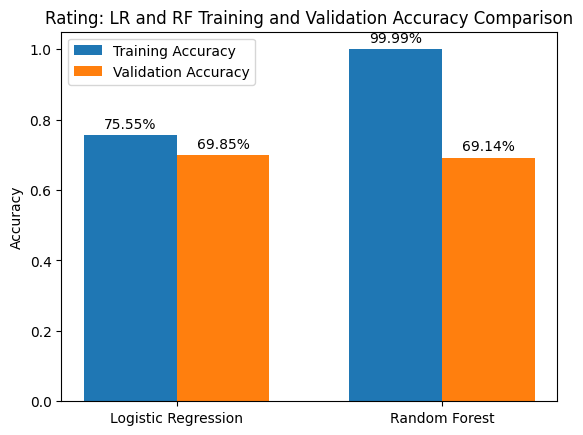

In [19]:
# Get training accuracy for both models
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train_final))
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_final))

# Plotting
labels = ['Logistic Regression', 'Random Forest']
train_accuracies = [lr_train_accuracy, rf_train_accuracy]
test_accuracies = [lr_accuracy, rf_accuracy]

rat_lr_train_accuracy = lr_train_accuracy
rat_rf_train_accuracy = rf_train_accuracy

rat_lr_test_accuracy = lr_accuracy
rat_rf_test_accuracy = rf_accuracy

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation Accuracy')

# Adding labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Rating: LR and RF Training and Validation Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotating the bars with actual values
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

# Display the plot
plt.show()

# Compare Effect of all features

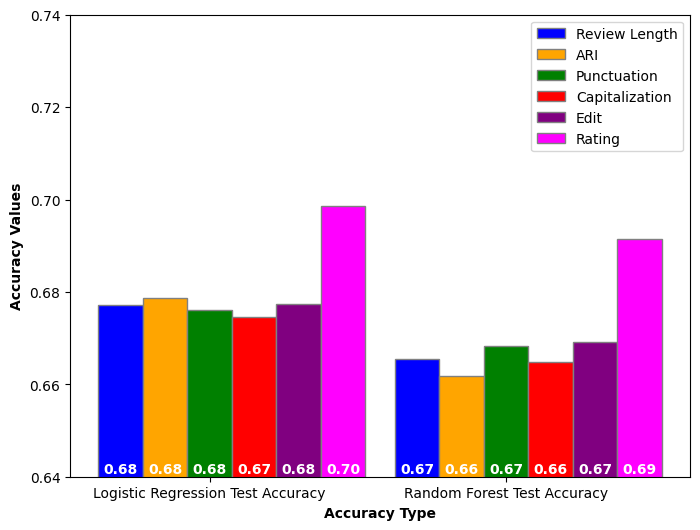

In [32]:
# Labels for the groups
labels = ['Logistic Regression Test Accuracy', 'Random Forest Test Accuracy']

# Width of the bars
bar_width = 0.15

# Extract values for LR Test and RF Test
len_values_subset = [len_lr_test_accuracy, len_rf_test_accuracy]
ari_values_subset = [ari_lr_test_accuracy, ari_rf_test_accuracy]
pct_values_subset = [pct_lr_test_accuracy, pct_rf_test_accuracy]
cap_values_subset = [cap_lr_test_accuracy, cap_rf_test_accuracy]
ed_values_subset = [ed_lr_test_accuracy, ed_rf_test_accuracy]
rat_values_subset = [rat_lr_test_accuracy, rat_rf_test_accuracy]


# Set the positions of bars on X-axis
r1_subset = np.arange(len(labels))
r2_subset = [x + bar_width for x in r1_subset]
r3_subset = [x + bar_width for x in r2_subset]
r4_subset = [x + bar_width for x in r3_subset]
r5_subset = [x + bar_width for x in r4_subset]
r6_subset = [x + bar_width for x in r5_subset]


# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(r1_subset, len_values_subset, color='blue', width=bar_width, edgecolor='grey', label='Review Length')
ax.bar(r2_subset, ari_values_subset, color='orange', width=bar_width, edgecolor='grey', label='ARI')
ax.bar(r3_subset, pct_values_subset, color='green', width=bar_width, edgecolor='grey', label='Punctuation')
ax.bar(r4_subset, cap_values_subset, color='red', width=bar_width, edgecolor='grey', label='Capitalization')
ax.bar(r5_subset, ed_values_subset, color='purple', width=bar_width, edgecolor='grey', label='Edit')
ax.bar(r6_subset, rat_values_subset, color='magenta', width=bar_width, edgecolor='grey', label='Rating')


# Adding labels
plt.xlabel('Accuracy Type', fontweight='bold')
plt.ylabel('Accuracy Values', fontweight='bold')
ax.set_xticks([r + 2*bar_width for r in range(len(labels))])
ax.set_xticklabels(labels)

# Adding legend
ax.legend()

# Adding values to the bars
for r, values in zip([r1_subset, r2_subset, r3_subset, r4_subset, r5_subset, r6_subset], [len_values_subset, ari_values_subset, pct_values_subset, cap_values_subset, ed_values_subset, rat_values_subset]):
    for i, value in enumerate(values):
        ax.text(r[i], 0.64, f'{value:.2f}', ha='center', va='bottom', color='white', weight='bold')

# Set the y-axis limit between 0.6 and 0.7
ax.set_ylim(0.64, 0.74)

# Display the plot
plt.show()